In [31]:
# === 1. Imports & Setup ===
import pandas as pd
import os
import numpy as np
from bs4 import BeautifulSoup
import requests
import re
import textstat
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import pickle
import json

# Optional (for display)
import matplotlib.pyplot as plt
import seaborn as sns

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

print("✅ Libraries imported successfully!")


✅ Libraries imported successfully!


In [34]:
base_dir = os.path.dirname(os.getcwd())  # goes up from notebooks/ to seo-content-detector/
data_dir = os.path.join(base_dir, "data")
os.makedirs(data_dir, exist_ok=True)

# Load dataset safely
data_path = os.path.join(data_dir, "data.csv")
df = pd.read_csv(data_path)

print(f"✅ Loaded data from: {data_path}")

df.head()


✅ Loaded data from: /Users/chittesh.k/Documents/seo-content-detector/data/data.csv


,url,html_content
0,https://www.cm-alliance.com/cybersecurity-blog,"<!doctype html><!--[if lt IE 7]> <html class=""..."
1,https://www.varonis.com/blog/cybersecurity-tips,"<!doctype html><html lang=""en""><head>\n <me..."
2,https://www.cisecurity.org/insights/blog/11-cy...,<!DOCTYPE html><html data-unhead-vue-server-re...
3,https://www.cisa.gov/topics/cybersecurity-best...,"\n\n<!DOCTYPE html>\n<html lang=""en"" dir=""ltr""..."
4,https://www.qnbtrust.bank/Resources/Learning-C...,NaN


In [35]:
# === 3. Parse HTML and Extract Text ===

def extract_text_from_html(html_content):
    try:
        soup = BeautifulSoup(html_content, 'html.parser')
        # Extract title
        title = soup.title.string if soup.title else ""
        # Extract main text (from <p> and <article>)
        paragraphs = soup.find_all(['p', 'article'])
        body_text = " ".join([p.get_text(separator=' ') for p in paragraphs])
        body_text = re.sub(r'\s+', ' ', body_text).strip()
        return title, body_text
    except Exception as e:
        print(f"⚠️ Error parsing HTML: {e}")
        return "", ""

# Apply function to each row
parsed_data = []
for idx, row in df.iterrows():
    title, body_text = extract_text_from_html(row['html_content'])
    word_count = len(body_text.split())
    parsed_data.append([row['url'], title, body_text, word_count])

parsed_df = pd.DataFrame(parsed_data, columns=['url', 'title', 'body_text', 'word_count'])

# Save to CSV
base_dir = os.path.dirname(os.getcwd())

# Define data directory in project root
data_dir = os.path.join(base_dir, "data")
os.makedirs(data_dir, exist_ok=True)

# Define and save file path
output_path = os.path.join(data_dir, "extracted_content.csv")
parsed_df.to_csv(output_path, index=False)

print(f"✅ Saved extracted content to: {output_path}")

parsed_df.head()


⚠️ Error parsing HTML: Incoming markup is of an invalid type: nan. Markup must be a string, a bytestring, or an open filehandle.
⚠️ Error parsing HTML: Incoming markup is of an invalid type: nan. Markup must be a string, a bytestring, or an open filehandle.
⚠️ Error parsing HTML: Incoming markup is of an invalid type: nan. Markup must be a string, a bytestring, or an open filehandle.
⚠️ Error parsing HTML: Incoming markup is of an invalid type: nan. Markup must be a string, a bytestring, or an open filehandle.
⚠️ Error parsing HTML: Incoming markup is of an invalid type: nan. Markup must be a string, a bytestring, or an open filehandle.
⚠️ Error parsing HTML: Incoming markup is of an invalid type: nan. Markup must be a string, a bytestring, or an open filehandle.
⚠️ Error parsing HTML: Incoming markup is of an invalid type: nan. Markup must be a string, a bytestring, or an open filehandle.
⚠️ Error parsing HTML: Incoming markup is of an invalid type: nan. Markup must be a string, a byt

,url,title,body_text,word_count
0,https://www.cm-alliance.com/cybersecurity-blog,Cyber Security Blog,Cyber Crisis Tabletop Exercise Cyber Security ...,326
1,https://www.varonis.com/blog/cybersecurity-tips,Top 10 Cybersecurity Awareness Tips: How to St...,The #1 Data Security Platform WHERE TO BUY CAP...,3713
2,https://www.cisecurity.org/insights/blog/11-cy...,11 Cyber Defense Tips to Stay Secure at Work a...,Cybersecurity is inextricably tied to the tech...,953
3,https://www.cisa.gov/topics/cybersecurity-best...,Cybersecurity Best Practices | Cybersecurity a...,An official website of the United States gover...,612
4,https://www.qnbtrust.bank/Resources/Learning-C...,,,0


Using 'url' as the text column for feature extraction.
Shape of dataset: (81, 6)

Columns:
 ['url', 'title', 'body_text', 'word_count', 'sentence_count', 'flesch_reading_ease']

Sample rows:
                                                  url  \
0     https://www.cm-alliance.com/cybersecurity-blog   
1    https://www.varonis.com/blog/cybersecurity-tips   
2  https://www.cisecurity.org/insights/blog/11-cy...   

                                               title  \
0                                Cyber Security Blog   
1  Top 10 Cybersecurity Awareness Tips: How to St...   
2  11 Cyber Defense Tips to Stay Secure at Work a...   

                                           body_text  word_count  \
0  Cyber Crisis Tabletop Exercise Cyber Security ...         326   
1  The #1 Data Security Platform WHERE TO BUY CAP...        3713   
2  Cybersecurity is inextricably tied to the tech...         953   

   sentence_count  flesch_reading_ease  
0               2              -724.78  
1  

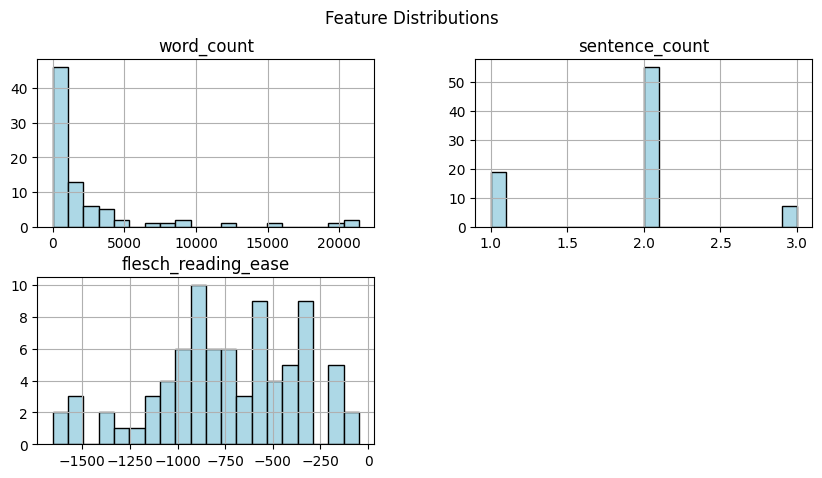

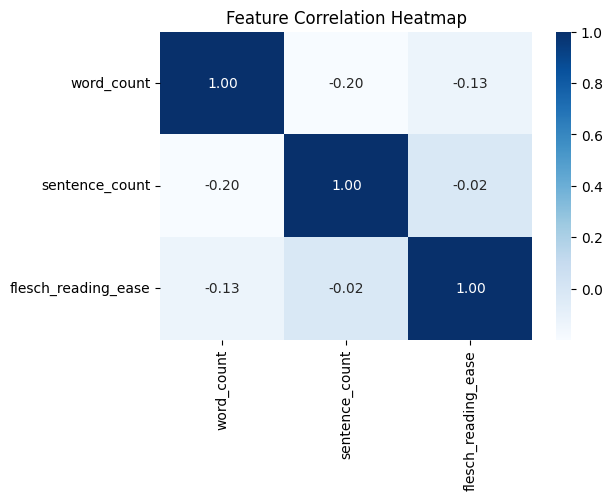

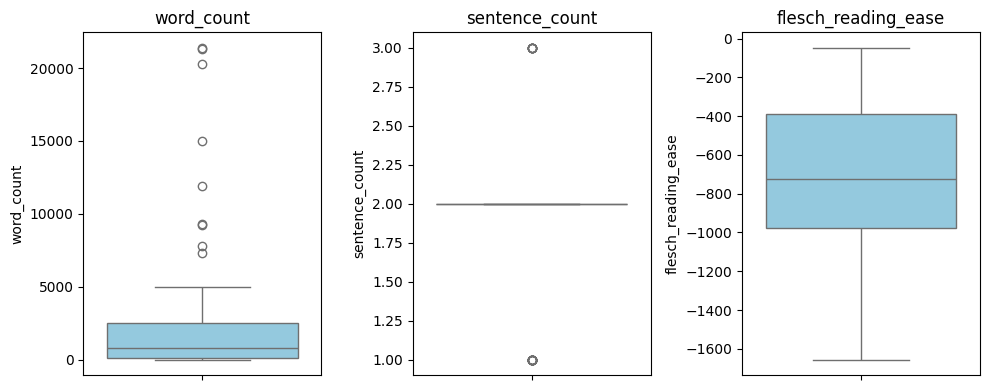


Variance Inflation Factor (VIF):
                Feature       VIF
0           word_count  1.289698
1       sentence_count  3.554494
2  flesch_reading_ease  3.822053


In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
import textstat

# === Auto-detect text column ===
text_columns = [col for col in parsed_df.columns if parsed_df[col].dtype == object]
if len(text_columns) == 0:
    raise ValueError("No text column found in the DataFrame.")
text_column = text_columns[0]  # Pick the first object column as text

print(f"Using '{text_column}' as the text column for feature extraction.")

# === Compute features if missing ===
if 'word_count' not in parsed_df.columns:
    parsed_df['word_count'] = parsed_df[text_column].apply(lambda x: len(str(x).split()))
if 'sentence_count' not in parsed_df.columns:
    parsed_df['sentence_count'] = parsed_df[text_column].apply(
        lambda x: str(x).count('.') + str(x).count('!') + str(x).count('?')
    )
if 'flesch_reading_ease' not in parsed_df.columns:
    parsed_df['flesch_reading_ease'] = parsed_df[text_column].apply(
        lambda x: textstat.flesch_reading_ease(str(x))
    )

# === Dataset Overview ===
print("Shape of dataset:", parsed_df.shape)
print("\nColumns:\n", parsed_df.columns.tolist())
print("\nSample rows:\n", parsed_df.head(3))

# === Missing Values ===
print("\nMissing values per column:\n", parsed_df.isnull().sum())

# === Descriptive Statistics ===
features = ['word_count', 'sentence_count', 'flesch_reading_ease']
print("\nDescriptive Statistics:\n", parsed_df[features].describe())

# === Label Distribution ===
if 'quality_label' in parsed_df.columns:
    plt.figure(figsize=(5,4))
    parsed_df['quality_label'].value_counts().plot(kind='bar', color='teal')
    plt.title("Distribution of Quality Labels")
    plt.xlabel("Quality Category")
    plt.ylabel("Count")
    plt.show()

# === Feature Histograms ===
parsed_df[features].hist(figsize=(10,5), bins=20, color='lightblue', edgecolor='black')
plt.suptitle("Feature Distributions")
plt.show()

# === Correlation Heatmap ===
plt.figure(figsize=(6,4))
sns.heatmap(parsed_df[features].corr(), annot=True, cmap='Blues', fmt='.2f')
plt.title("Feature Correlation Heatmap")
plt.show()

# === Boxplots (Outlier Check) ===
plt.figure(figsize=(10,4))
for i, col in enumerate(features, 1):
    plt.subplot(1,3,i)
    sns.boxplot(y=parsed_df[col], color='skyblue')
    plt.title(col)
plt.tight_layout()
plt.show()

# === Variance Inflation Factor (VIF) ===
X = parsed_df[features].dropna()
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print("\nVariance Inflation Factor (VIF):\n", vif_data)


In [42]:
# === 4. Feature Engineering ===

def extract_features(text):
    try:
        readability = textstat.flesch_reading_ease(text)
        sentence_count = len(re.split(r'[.!?]+', text))
        return readability, sentence_count
    except:
        return 0, 0

parsed_df['flesch_reading_ease'], parsed_df['sentence_count'] = zip(
    *parsed_df['body_text'].apply(extract_features)
)

# TF-IDF for keyword extraction
vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
tfidf_matrix = vectorizer.fit_transform(parsed_df['body_text'])

# Top 5 keywords per document
feature_names = np.array(vectorizer.get_feature_names_out())
top_keywords = []
for row in tfidf_matrix:
    indices = np.argsort(row.toarray()).flatten()[::-1][:5]
    top_keywords.append("|".join(feature_names[indices]))

parsed_df['top_keywords'] = top_keywords

# Save features
parsed_df.to_csv("../data/features.csv", index=False)
parsed_df.head()




,url,title,body_text,word_count,sentence_count,flesch_reading_ease,top_keywords
0,https://www.cm-alliance.com/cybersecurity-blog,Cyber Security Blog,Cyber Crisis Tabletop Exercise Cyber Security ...,326,8,-6.816181,cyber|cybersecurity|training|events|management
1,https://www.varonis.com/blog/cybersecurity-tips,Top 10 Cybersecurity Awareness Tips: How to St...,The #1 Data Security Platform WHERE TO BUY CAP...,3713,209,38.448939,data|security|access|app|sensitive
2,https://www.cisecurity.org/insights/blog/11-cy...,11 Cyber Defense Tips to Stay Secure at Work a...,Cybersecurity is inextricably tied to the tech...,953,62,53.480384,protect|authentication|device|use|don
3,https://www.cisa.gov/topics/cybersecurity-best...,Cybersecurity Best Practices | Cybersecurity a...,An official website of the United States gover...,612,34,15.798421,cyber|cybersecurity|government|secure|practices
4,https://www.qnbtrust.bank/Resources/Learning-C...,,,0,1,0.000000,ztna|exfiltrated|factor|fact|faced


In [43]:
# === Robust Batch Analysis: Duplicate & Thin Content Detection (defensive) ===
import os
os.makedirs('data', exist_ok=True) 
import pandas as pd
import numpy as np
import itertools
import scipy.sparse as sp
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity, linear_kernel
import time
import gc

start_time = time.time()

# --- Safeguard: check parsed_df exists ---
try:
    parsed_df
except NameError:
    raise RuntimeError("parsed_df not found. Run the parsing / feature extraction cell first to create parsed_df.")

# --- Ensure text column is present and cleaned ---
text_col_candidates = ['clean_text', 'body_text', 'text', 'content']
text_col = None
for c in text_col_candidates:
    if c in parsed_df.columns:
        text_col = c
        break

if text_col is None:
    raise RuntimeError("No text column found in parsed_df. Expected one of: " + ", ".join(text_col_candidates))

# Fill NaNs and ensure strings
parsed_df[text_col] = parsed_df[text_col].fillna('').astype(str)
parsed_df = parsed_df.reset_index(drop=True)

n_docs = len(parsed_df)
print(f"Documents to analyze: {n_docs}")
if n_docs == 0:
    raise RuntimeError("parsed_df is empty after cleaning.")

# Quick sanity print
print("Example text (first doc):", parsed_df[text_col].iloc[0][:200])

# --- TF-IDF vectorization ---
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
tfidf_matrix = vectorizer.fit_transform(parsed_df[text_col])   # sparse matrix, shape (n_docs, n_features)
print("TF-IDF shape:", tfidf_matrix.shape)

# --- Memory-friendly duplicate search ---
threshold = 0.80
print(f"Searching duplicate pairs with threshold = {threshold} ...")

# Approach: use sparse matrix multiplication (linear_kernel / dot product) row-by-row to avoid building full dense matrix.
duplicate_pairs = []
# If dataset is small (<2000), you may compute full similarity; else iterate
MAX_FULL_MATRIX = 1500   # safe threshold for dense matrix (tune if you have more memory)
if n_docs <= MAX_FULL_MATRIX:
    print("Computing full similarity matrix (dense) — small dataset path.")
    sim_mat = cosine_similarity(tfidf_matrix)            # returns dense array (n x n)
    # Only look at upper triangle (i < j)
    iu = np.triu_indices(n_docs, k=1)
    vals = sim_mat[iu]
    idxs = np.where(vals > threshold)[0]
    for k in idxs:
        i = iu[0][k]
        j = iu[1][k]
        duplicate_pairs.append({
            'url1': parsed_df.loc[i, 'url'],
            'url2': parsed_df.loc[j, 'url'],
            'similarity': float(sim_mat[i, j])
        })
    # free memory
    del sim_mat
    gc.collect()
else:
    print("Large dataset path: computing similarities row-by-row (sparse-safe).")
    # For each document i, compute similarity to docs j>i using dot product with tfidf_matrix
    # linear_kernel is equivalent to cosine similarity on l2-normalized TF-IDF
    for i in range(n_docs):
        row_vec = tfidf_matrix[i]
        # compute similarity of doc i to all docs (dense 1 x n array)
        sims = linear_kernel(row_vec, tfidf_matrix).ravel()   # faster and works with sparse
        # ignore self
        sims[i] = 0.0
        # only keep j > i to avoid duplicates
        candidate_idxs = np.where(sims > threshold)[0]
        candidate_idxs = candidate_idxs[candidate_idxs > i]
        for j in candidate_idxs:
            duplicate_pairs.append({
                'url1': parsed_df.loc[i, 'url'],
                'url2': parsed_df.loc[j, 'url'],
                'similarity': float(sims[j])
            })
        # optional: progress print every 500
        if (i + 1) % 500 == 0:
            print(f"Processed {i+1}/{n_docs} rows...")
    gc.collect()

# Save duplicates DataFrame
duplicates_df = pd.DataFrame(duplicate_pairs)
duplicates_path = 'data/duplicates.csv'
duplicates_df.to_csv(duplicates_path, index=False)
print(f"Saved {len(duplicates_df)} duplicate pairs to {duplicates_path}")

# Thin content detection
parsed_df['is_thin'] = parsed_df['word_count'] < 500
thin_count = int(parsed_df['is_thin'].sum())
print(f"Thin content pages (word_count < 500): {thin_count} / {n_docs}")

# Save features CSV (features already in parsed_df)
features_path = 'data/features.csv'
parsed_df.to_csv(features_path, index=False)
print(f"Saved features to {features_path}")

end_time = time.time()
print(f"Batch duplicate detection finished in {end_time - start_time:.1f} seconds.")


Documents to analyze: 81
Example text (first doc): Cyber Crisis Tabletop Exercise Cyber Security Awareness Training for Executives Prepare to respond to ransomware attacks Learn how to Plan, Produce & Conduct Tabletop Exercises Validate your ransomwar
TF-IDF shape: (81, 5000)
Searching duplicate pairs with threshold = 0.8 ...
Computing full similarity matrix (dense) — small dataset path.
Saved 1 duplicate pairs to data/duplicates.csv
Thin content pages (word_count < 500): 36 / 81
Saved features to data/features.csv
Batch duplicate detection finished in 1.3 seconds.


In [45]:
# === 5. Duplicate Detection ===
similarity_matrix = cosine_similarity(tfidf_matrix)
threshold = 0.8
duplicates = []

for i in range(len(parsed_df)):
    for j in range(i + 1, len(parsed_df)):
        if similarity_matrix[i][j] > threshold:
            duplicates.append([parsed_df.loc[i, 'url'], parsed_df.loc[j, 'url'], similarity_matrix[i][j]])

duplicates_df = pd.DataFrame(duplicates, columns=['url1', 'url2', 'similarity'])
duplicates_df.to_csv("../data/duplicates.csv", index=False)

print(f"Total duplicate pairs found: {len(duplicates_df)}")
duplicates_df.head()


Total duplicate pairs found: 1


,url1,url2,similarity
0,https://en.wikipedia.org/wiki/SD-WAN,https://www.fortinet.com/resources/cyberglossa...,0.861195


In [46]:
# === 6. Label Creation ===
def label_quality(row):
    if row['word_count'] > 1500 and 50 <= row['flesch_reading_ease'] <= 70:
        return 'High'
    elif row['word_count'] < 500 or row['flesch_reading_ease'] < 30:
        return 'Low'
    else:
        return 'Medium'

parsed_df['quality_label'] = parsed_df.apply(label_quality, axis=1)


Classification Report:

              precision    recall  f1-score   support

        High       1.00      0.50      0.67         2
         Low       1.00      0.87      0.93        15
      Medium       0.73      1.00      0.84         8

    accuracy                           0.88        25
   macro avg       0.91      0.79      0.81        25
weighted avg       0.91      0.88      0.88        25



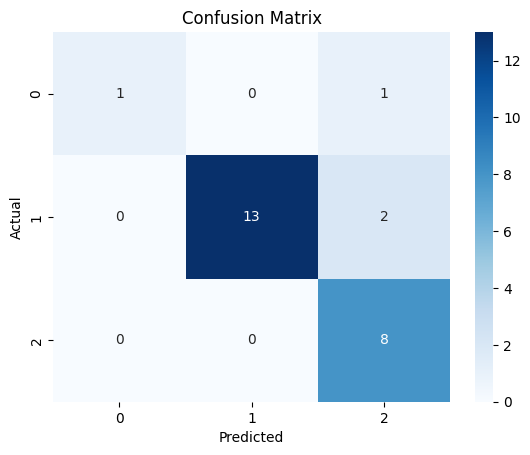

Accuracy: 0.88
McFadden's Pseudo-R²: 0.71
✅ Model saved successfully at ../streamlit_app/models/quality_model.pkl


In [ ]:
# === Imports ===
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# === 1. Features and Labels ===
features = parsed_df[['word_count', 'sentence_count', 'flesch_reading_ease']]
labels = parsed_df['quality_label']

# === 2. Train/Test Split (stratified) ===
X_train, X_test, y_train, y_test = train_test_split(
    features, labels, test_size=0.3, random_state=42, stratify=labels
)

# === 3. Random Forest + Hyperparameter Tuning ===
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5]
}

grid = GridSearchCV(
    RandomForestClassifier(random_state=42, class_weight='balanced'),
    param_grid,
    cv=StratifiedKFold(n_splits=5),
    scoring='f1_weighted',
    n_jobs=-1
)
grid.fit(X_train, y_train)
best_model = grid.best_estimator_

# === 4. Predictions ===
y_pred = best_model.predict(X_test)

# === 5. Classification Report ===
print("Classification Report:\n")
print(classification_report(y_test, y_pred))

# === 6. Confusion Matrix ===
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# === 7. Accuracy ===
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", round(accuracy, 3))

# === 8. McFadden's Pseudo-R² ===
# Convert labels to numeric
y_test_num = pd.factorize(y_test)[0]
y_pred_proba = best_model.predict_proba(X_test)

# Log-likelihood of the model
eps = 1e-15
ll_model = np.sum(np.log(y_pred_proba[np.arange(len(y_test_num)), y_test_num] + eps))

# Log-likelihood of null model (predicting class frequencies)
class_counts = np.bincount(y_test_num)
probs_null = class_counts / len(y_test_num)
ll_null = np.sum(np.log(probs_null[y_test_num] + eps))

pseudo_r2 = 1 - (ll_model / ll_null)
print("McFadden's Pseudo-R²:", round(pseudo_r2, 3))

import joblib
import os

# Ensure models directory exists
os.makedirs("../streamlit_app/models", exist_ok=True)

# Save trained model
model_path = "../streamlit_app/models/quality_model.pkl"
joblib.dump(best_model, model_path)

print(f" Model saved successfully at {model_path}")



In [48]:
# === 8. Real-Time URL Analysis ===
def analyze_url(url):
    try:
        response = requests.get(url, headers={'User-Agent': 'Mozilla/5.0'}, timeout=10)
        soup = BeautifulSoup(response.text, 'html.parser')
        title = soup.title.string if soup.title else ""
        paragraphs = soup.find_all(['p', 'article'])
        body_text = " ".join([p.get_text(separator=' ') for p in paragraphs])
        body_text = re.sub(r'\s+', ' ', body_text).strip()

        readability = textstat.flesch_reading_ease(body_text)
        sentence_count = len(re.split(r'[.!?]+', body_text))
        word_count = len(body_text.split())

        thin = word_count < 500

        X = pd.DataFrame([[word_count, sentence_count, readability]],
                         columns=['word_count', 'sentence_count', 'flesch_reading_ease'])
        quality_label = model.predict(X)[0]

        # Find similar pages
        vec = vectorizer.transform([body_text])
        sims = cosine_similarity(vec, tfidf_matrix).flatten()
        similar_idx = np.argsort(sims)[::-1][:3]
        similar_pages = [
            {'url': parsed_df.loc[i, 'url'], 'similarity': round(sims[i], 2)}
            for i in similar_idx if sims[i] > 0.5
        ]

        return {
            "url": url,
            "title": title,
            "word_count": word_count,
            "readability": readability,
            "quality_label": quality_label,
            "is_thin": thin,
            "similar_to": similar_pages
        }
    except Exception as e:
        return {"error": str(e)}

# Test
result = analyze_url("https://example.com")
print(json.dumps(result, indent=2))


{
  "url": "https://example.com",
  "title": "Example Domain",
  "word_count": 19,
  "readability": 49.01719298245615,
  "quality_label": "Low",
  "is_thin": true,
  "similar_to": []
}
